#  Проект Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Анализ

Импортируем библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_STATE = 537894

In [3]:
 data = pd.read_csv('users_behavior.csv')

Посмотрим на размерность таблицы

In [4]:
data.shape

(3214, 5)

Проверим как выглядит дата

In [5]:
display(data.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Таблица не очень большая, сможем в деталях посмотреть все столбцы

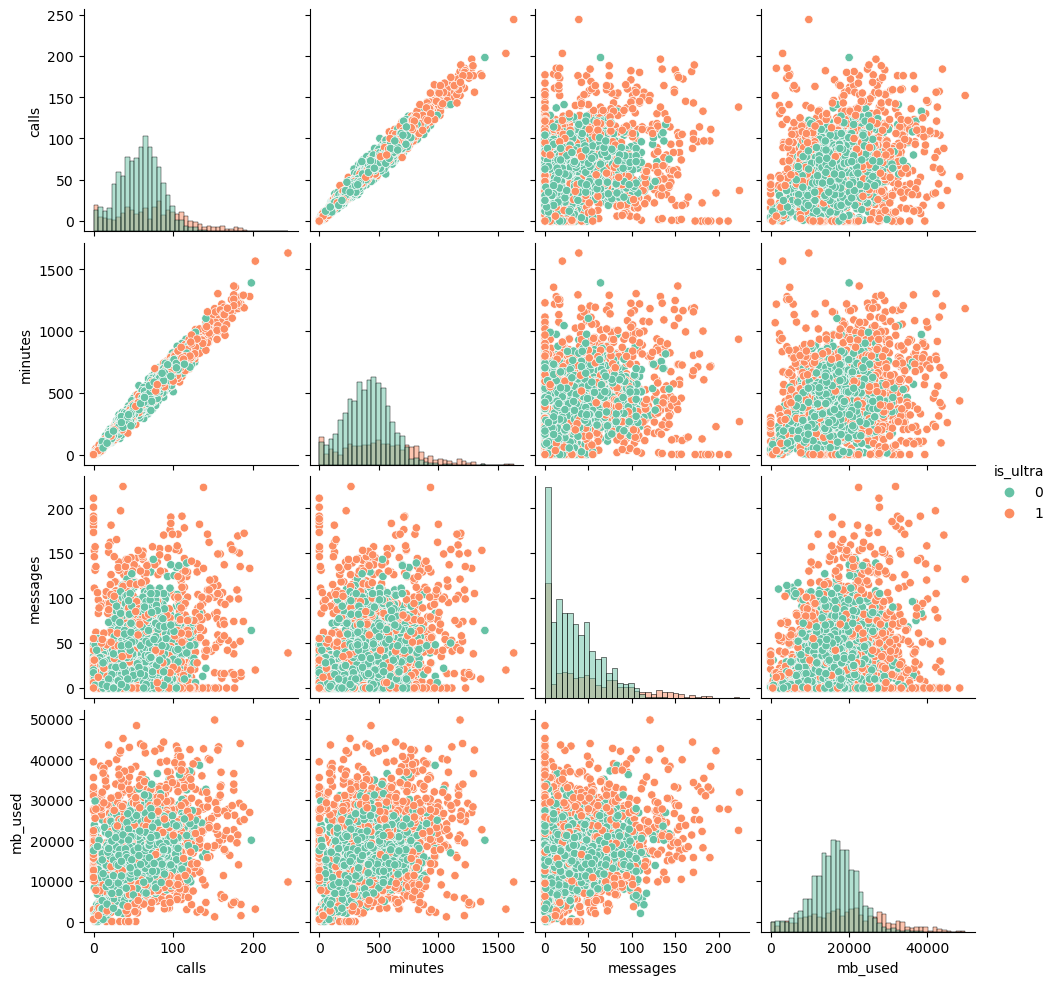

In [6]:
sns.pairplot(data, hue="is_ultra", diag_kind="hist", palette = 'Set2');

Из пэйрплота сразу видно, что между минутами и звонками есть корреляция значимая, также видно, что клиенты тарифа ультра как правило имеют более выраженные значения по всем параметрам, то есть могут и больше всего сообщений посылать и больше минут говорить и звонки чаще совершать, а самые средние значения как правило принадлежат клиентам тарифа смарт.

### calls

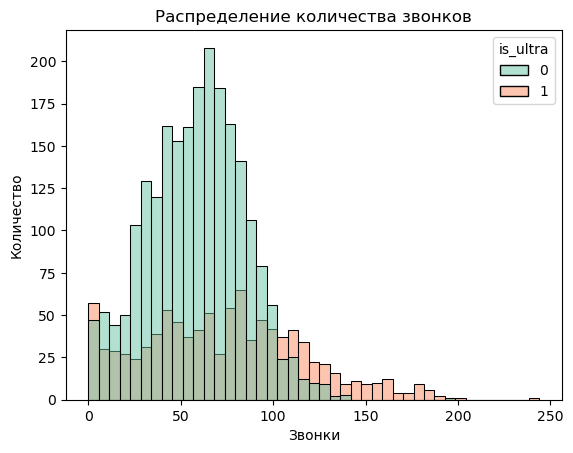

In [7]:
sns.histplot(data = data, x ='calls', palette='Set2', hue='is_ultra')
plt.title('Распределение количества звонков')
plt.xlabel('Звонки')
plt.ylabel('Количество')
plt.show();

* Пользователи тарифа смарт не совершают обычно звонков больше 100, большинство звонит от 25 до 100 раз.
* Пользователи тарифа ультра имеют более длинный график распределения, и чаще звонят больше 100 раз

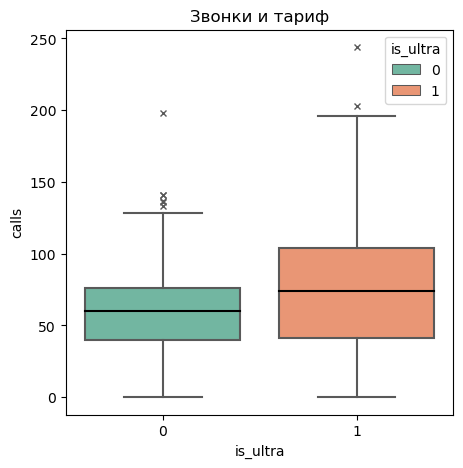

In [8]:
plt.figure(figsize=(5,5), dpi= 100)
sns.boxplot(y='calls', x='is_ultra', data=data, notch=False, hue='is_ultra', dodge=False, flierprops={"marker": "x"},\
           medianprops={"color": "black"}, palette="Set2");
plt.title('Звонки и тариф')
plt.show();

* У пользователей ультра разброс больше, медиана больше и выбросов меньше по количеству звонкам

### minutes

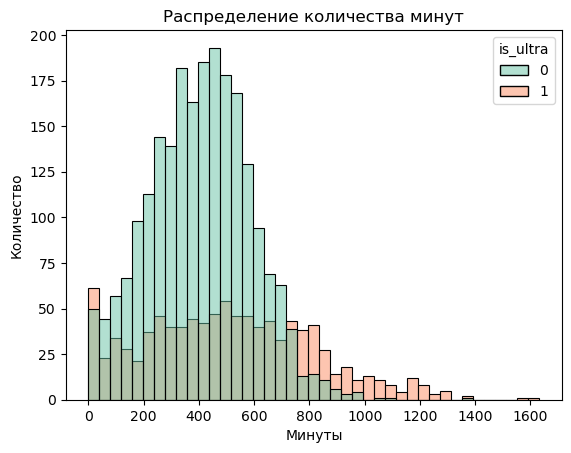

In [9]:
sns.histplot(data = data, x ='minutes', palette='Set2', hue='is_ultra')
plt.title('Распределение количества минут')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.show();

* С минутами ситуация похожая на звонки, это связанные вещи, чем больше звонят, тем скорее всего и общее количество минут проведенных на звонке вырастает
* Пользователи тарифа смарт говорят обычно от 200 до 600 минут 
* Пользователи тарифа ультра могут наговорить и больше 800 минут и даже есть ультра выраженные значения 1600 минут, но это скорее выбросы, надо будет посмотреть на боксплоте

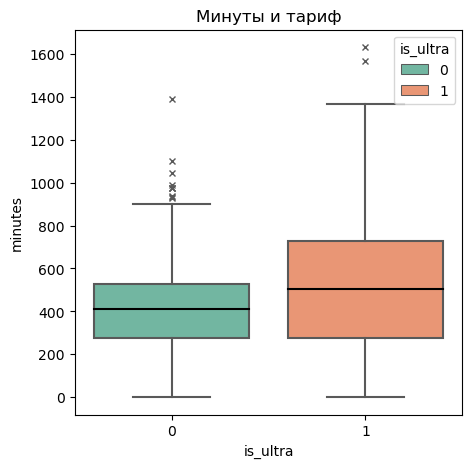

In [10]:
plt.figure(figsize=(5,5), dpi= 100)
sns.boxplot(y='minutes', x='is_ultra', data=data, notch=False, hue='is_ultra', dodge=False, flierprops={"marker": "x"},\
           medianprops={"color": "black"}, palette="Set2");
plt.title('Минуты и тариф')
plt.show();

* Та же картина с минутами, выбросов меньше, медиана выше, сам ящик шире - у пользователей ультра

### messages

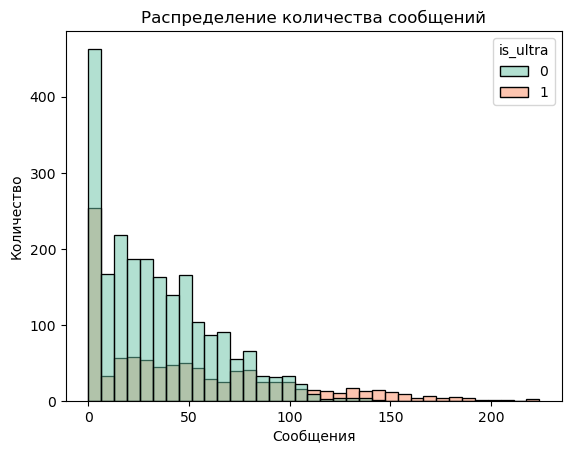

In [11]:
sns.histplot(data = data, x ='messages', palette='Set2', hue='is_ultra')
plt.title('Распределение количества сообщений')
plt.xlabel('Сообщения')
plt.ylabel('Количество')
plt.show();

* Пользователи тарифа смарт могут почти не использовать сообщения, илил использовать, но очень мало, у нас график с явной ассиметрией в левую сторону
* Но, при этом, пользователи тарифа ультра могут слать больше сообщений, даже больше 150

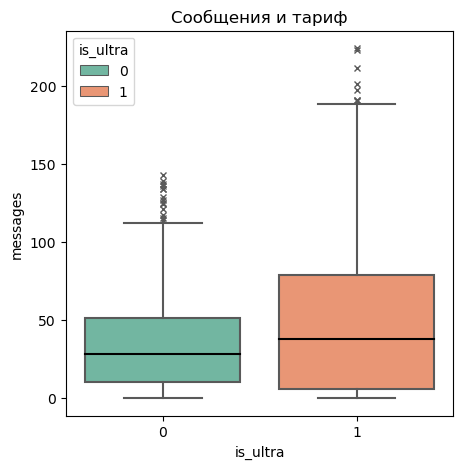

In [12]:
plt.figure(figsize=(5,5), dpi= 100)
sns.boxplot(y='messages', x='is_ultra', data=data, notch=False, hue='is_ultra', dodge=False, flierprops={"marker": "x"},\
           medianprops={"color": "black"}, palette="Set2");
plt.title('Сообщения и тариф')
plt.show();

* Сам ящик у тарифа ультра шире, а "ус" намного длиннее, медиана выше

### mb_used

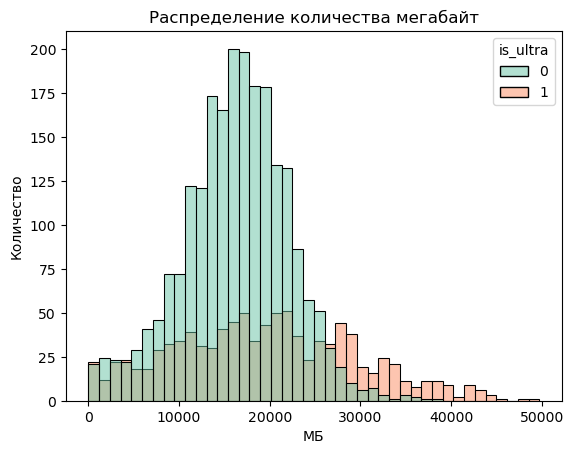

In [13]:
sns.histplot(data = data, x ='mb_used', palette='Set2', hue='is_ultra')
plt.title('Распределение количества мегабайт')
plt.xlabel('МБ')
plt.ylabel('Количество')
plt.show();

* Пользователи тарифа смарт в основном пользуются от 10000 до 25000 МБ, у ультра более равномерное распределение

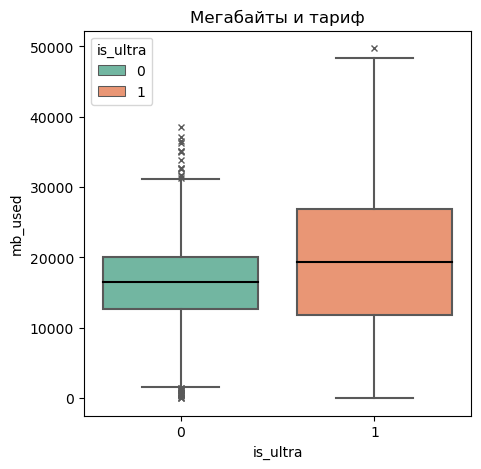

In [14]:
plt.figure(figsize=(5,5), dpi= 100)
sns.boxplot(y='mb_used', x='is_ultra', data=data, notch=False, hue='is_ultra', dodge=False, flierprops={"marker": "x"},\
           medianprops={"color": "black"}, palette="Set2");
plt.title('Мегабайты и тариф')
plt.show();

* У смарта есть выбросы даже в нижней части боксплота, то есть аномально низкие значения и аномально высокие тоже есть и их больше чем у пользователей тарифа ультра
* У ультра сам ящик опять же шире и медиана больше

### is_ultra

In [15]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

- клиентов ультра ото всех клиентов - 30.65%

### Корреляция

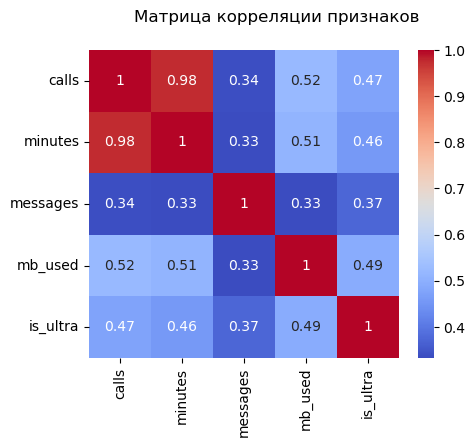

In [16]:
int_cols = ['calls', 'minutes', 'messages', 'mb_used']

matrix = data.phik_matrix(interval_cols=int_cols)
plt.figure(figsize=(5,4))
plt.suptitle('Матрица корреляции признаков')
sns.heatmap(matrix, cmap="coolwarm", annot=True)
plt.show();

* Здесь видно, что минуты и звонки связаны очень сильно, думаю стоит один из этих столбцов убрать, так как это будет мешать, уберу тот, который имеет меньшую корреляцию с целевым признаком.
* Есть заметная корреляция между МБ и звонками с минутами. 
* А также есть есть корреляция МБ с целевым признаком.

### Тариф смарт

In [17]:
data[data['is_ultra'] == 0].describe()

,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


В итоге, для пользователей тарифа смарт:

- Среднее количество **звонков** - 58, медиана - 60

- Среднее количество **минут** - 406, медиана - 410

- Среднее количество **сообщений** - 33, медиана - 28

- Среднее количество **Мб** - 16 Гб, медиана - 16 Гб

### Тариф ультра

In [18]:
data[data['is_ultra'] == 1].describe()

,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


Для пользователей тарифа ультра:

- Среднее количество **звонков** - 73, медиана - 74

- Среднее количество **минут** - 511, медиана - 502

- Среднее количество **сообщений** - 49, медиана - 38

- Среднее количество **Мб** - 19 Гб, медиана - 19 Гб

### calls и minutes

Самая сильная корреляция между минутами и звонками, посмотрим на графике

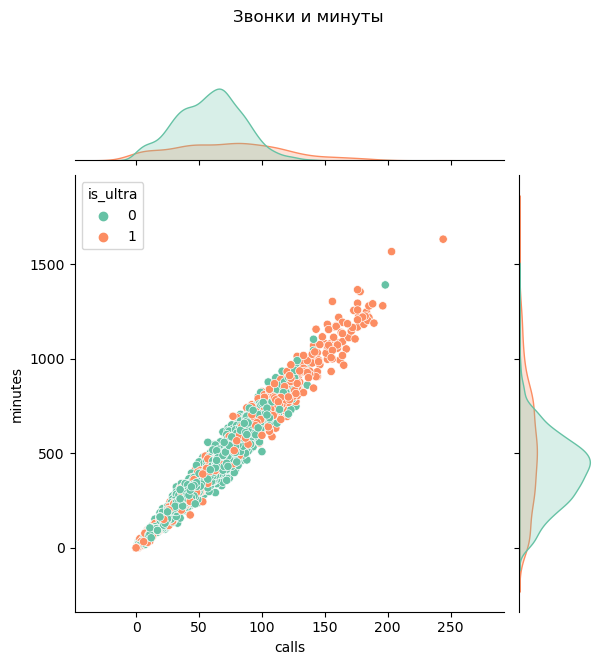

In [19]:
sns.jointplot(data=data, x="calls", y="minutes", hue="is_ultra", legend=True, palette='Set2')
plt.suptitle('Звонки и минуты', x=0.5, y=1.1)
plt.show();

 * Как минуты так и звонки имеют близкое к нормальному распределение у пользователей тарифа смарт
 * В то время как у пользователей тарифа ультра распределение более мягкое и длинное
 * Зависимость звонков от минут ярко линейная, достаточно сильная
 * Большинство клиентов с большим количеством минут и звонков - пользователи тарифа ультра, это видно по правому верхнему углу графика

## Модели

Убираем один столбец, чтобы исбежать мультиколлинеарности

In [20]:
data = data.drop('minutes', axis=1)

Разбиваем на выборки

In [21]:
train, test = train_test_split(data, test_size=0.3, random_state=RANDOM_STATE)
print(train.shape, test.shape)

(2249, 4) (965, 4)


In [22]:
train_f = train.drop(['is_ultra'], axis=1)
train_t = train['is_ultra']

test_f = test.drop(['is_ultra'], axis=1)
test_t = test['is_ultra']

In [23]:
scaler = StandardScaler()

scaler.fit_transform(train_f)

array([[ 1.61476507e+00,  9.90058777e-01,  1.31376086e+00],
       [ 1.39305913e-01, -2.96005358e-01,  2.60277170e-01],
       [ 6.70471210e-01, -4.97377575e-02, -1.44262262e-01],
       ...,
       [ 1.37869161e+00, -2.68642291e-01,  7.66652107e-04],
       [-1.26276736e-01, -1.86553091e-01, -1.25383739e+00],
       [-1.80830018e+00, -8.97992826e-01, -1.90866216e+00]])

Проведем бейзлайн, ниже которого не должна падать метрика

In [24]:
randmod = DummyClassifier(strategy="most_frequent").fit(train_f, train_t)

randmod_res = randmod.score(test_f, test_t)
print('Accuracy для базового классификатора:')
display(randmod_res)

Accuracy для базового классификатора:


0.7005181347150259

In [25]:
est1 = LogisticRegression(random_state=RANDOM_STATE)

p1 = {}
p1['classifier__C'] = [0.01, 0.1, 1]
p1['classifier__max_iter'] = [15, 50, 100, 150]
p1['classifier'] = [est1]

In [26]:
est2 = RandomForestClassifier(random_state=RANDOM_STATE)

p2 = {}
p2['classifier__n_estimators'] = [5, 10, 20, 50]
p2['classifier__max_depth'] = [5, 10, 20, 50]
p2['classifier'] = [est2]

In [27]:
est3 = DecisionTreeClassifier(random_state=RANDOM_STATE)

p3 = {}
p3['classifier__max_depth'] = [10, 30, 50, 150, 300]
p3['classifier__min_samples_split'] = [2,5,10]
p3['classifier'] = [est3]

In [28]:
pipeline = Pipeline([('classifier', est1)])
params = [p1, p2, p3]

In [29]:
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
skf 

StratifiedKFold(n_splits=5, random_state=537894, shuffle=True)

In [30]:
gridsearch = GridSearchCV(pipeline, params, cv=skf, n_jobs=-1, scoring='accuracy').fit(train_f, train_t)

In [31]:
gridsearch.best_params_

{'classifier': RandomForestClassifier(max_depth=10, n_estimators=20, random_state=537894),
 'classifier__max_depth': 10,
 'classifier__n_estimators': 20}

In [32]:
gridsearch.best_score_

0.8105637218510269

In [33]:
model = RandomForestClassifier(max_depth=10, n_estimators=20, random_state=RANDOM_STATE)

model.fit(train_f, train_t)

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=537894)

In [34]:
pred_test = gridsearch.predict_proba(test_f)
pred_one_test = pred_test[:,1]

acc_train = accuracy_score(test_t, gridsearch.predict(test_f))
print(acc_train)

0.8


In [35]:
pd.DataFrame({'Value':model.feature_importances_,'Feature':train_f.columns}).sort_values(by="Value",ascending=False).head()

,Value,Feature
2,0.389655,mb_used
0,0.340644,calls
1,0.269701,messages


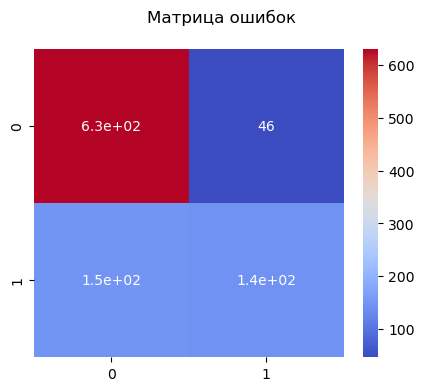

In [36]:
conf_mtx = confusion_matrix(test_t, gridsearch.predict(test_f))
plt.figure(figsize=(5, 4))
plt.suptitle('Матрица ошибок')
sns.heatmap(conf_mtx, cmap="coolwarm", annot=True)
plt.show();

т.е. 150 False Positive и 140 True Positive
- В целом я улучшила эти показатели, было почти половина на половину, сейчас намного лучше
- С учетом что у нас дисбаланс классов, матрица ошибок показвает неплохой результат

## Вывод

В результате анализа было обнаружено:
- Звонки и сообщения плотно связаны между собой
- Пользователи тарифа ультра могут совершать больше звонков, дольше разговаривают и используют больше МБ
- Среднее и медиана у пользователей тарифа ультра больше чем у пользователей тарифа смарт *по всем показателям*
- Нашей задачей было предсказать кем будет новый клиент? - будет он пользоваться тарифом смарт или ультра 
  - бейзлайн было 70% правильных ответов (всего 30% клиентов - пользователи тарифа ультра), так как у нас дисбаланс классов. 
  - Теперь с моделью RandomForestClassifier(max_depth=10, n_estimators=20, random_state=537894) у нас получился на тестовой выборке 80% правильного распределения тарифа
- Наибольшее значение для предсказания является количество МБ, которые клиент использует